# **CS598 Deep Learning for Healthcare**

## **1. Setup**

### 1.1 Change the google colab settings
We can use a GPU on the google colab by setting below.  
**Edit -> Notebook setting -> Hardware accelerator -> GPU**

### 1.2 Check if the GPU is available in the Colab environment

In [1]:
# The code in this cell is inspired by https://mccormickml.com/2019/07/22/BERT-fine-tuning/
import tensorflow as tf

# Get the GPU device name
device_name = tf.test.gpu_device_name()
print('Device name: {}'.format(device_name))

Device name: /device:GPU:0


### 1.3 GPU setting for PyTourch

In [2]:
# The code in this cell is inspired by https://mccormickml.com/2019/07/22/BERT-fine-tuning/
import torch

# Tell PyTorch to use the GPU
device = torch.device("cuda")
print('GPU:', torch.cuda.get_device_name(0))

GPU: Tesla P100-PCIE-16GB


### 1.4 Install necessary packages

In [3]:
!pip install tabgan

## **2. Dataset loading and data augmentation**

### 2.1 Load prepared data

In [4]:
#import os
#import pickle
#import random
import numpy as np
#import torch
#import torch.nn as nn
#import torch.nn.functional as F
import pandas as pd
import tabgan

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#
def read_emb_csv(filepath):
    #pd_x = pd.read_csv(filepath + 'x_18474_3348.csv')
    #pd_x = pd.read_csv(filepath + 'x_18474_3336.csv')
    pd_x = pd.read_csv(filepath + 'x_18312_606.csv')
    pd_y_charge = pd.read_csv(filepath + 'ycharge.csv')
    #pd_y_paid = pd.read_csv(filepath + 'ypaid.csv')
    pd_y_paid = pd.read_csv(filepath + 'ypaid_18312.csv')

    return pd_x, pd_y_charge, pd_y_paid

# load the emb csv
EMB_DATA_PATH = '/content/drive/MyDrive/iqvia_data/'
pd_x, pd_y_charge, pd_y_paid = read_emb_csv(EMB_DATA_PATH) 
    

In [7]:
print("pd_x: {}".format(pd_x.shape))
print("pd_y_charge: {}".format(pd_y_charge.shape))
print("pd_y_paid: {}".format(pd_y_paid.shape))

pd_x: (18311, 606)
pd_y_charge: (18473, 1)
pd_y_paid: (18311, 1)


In [8]:
pd_y_paid.describe()

,5.061299999999999955e+02
count,1.831100e+04
mean,1.818522e+03
std,1.467167e+04
min,0.000000e+00
25%,9.411000e+01
50%,3.047700e+02
75%,9.267250e+02
max,1.552063e+06


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0b6f0b5590>]],
      dtype=object)

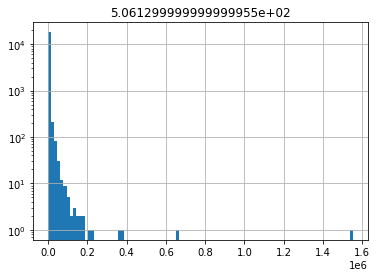

In [9]:
pd_y_paid.hist(bins=100, log=True)

In [10]:
outlier = np.where(pd_y_paid > 100000)[0]
print(outlier)
print(outlier.shape)
#print(pd_y_paid.loc[np.where(pd_y_paid > 100000)[0]])

[  194   442  1076  1343  1696  2909  3278  3853  4032  4473  5777  6600
  6767  6839  8166 11376 12221 12363 13057 16598]
(20,)


In [11]:
# Drop outlier
pd_x = pd_x.drop(index=outlier)
pd_y_paid = pd_y_paid.drop(index=outlier)

In [12]:
pd_x.describe()

,3.487200000000000273e+02,0.000000000000000000e+00,0.000000000000000000e+00.1,0.000000000000000000e+00.2,0.000000000000000000e+00.3,0.000000000000000000e+00.4,0.000000000000000000e+00.5,0.000000000000000000e+00.6,0.000000000000000000e+00.7,0.000000000000000000e+00.8,0.000000000000000000e+00.9,0.000000000000000000e+00.10,0.000000000000000000e+00.11,0.000000000000000000e+00.12,0.000000000000000000e+00.13,0.000000000000000000e+00.14,0.000000000000000000e+00.15,0.000000000000000000e+00.16,0.000000000000000000e+00.17,0.000000000000000000e+00.18,0.000000000000000000e+00.19,0.000000000000000000e+00.20,0.000000000000000000e+00.21,0.000000000000000000e+00.22,0.000000000000000000e+00.23,0.000000000000000000e+00.24,0.000000000000000000e+00.25,0.000000000000000000e+00.26,0.000000000000000000e+00.27,0.000000000000000000e+00.28,0.000000000000000000e+00.29,0.000000000000000000e+00.30,0.000000000000000000e+00.31,0.000000000000000000e+00.32,0.000000000000000000e+00.33,0.000000000000000000e+00.34,0.000000000000000000e+00.35,0.000000000000000000e+00.36,0.000000000000000000e+00.37,0.000000000000000000e+00.38,...,0.000000000000000000e+00.537,0.000000000000000000e+00.538,0.000000000000000000e+00.539,0.000000000000000000e+00.540,0.000000000000000000e+00.541,0.000000000000000000e+00.542,0.000000000000000000e+00.543,0.000000000000000000e+00.544,0.000000000000000000e+00.545,0.000000000000000000e+00.546,0.000000000000000000e+00.547,0.000000000000000000e+00.548,0.000000000000000000e+00.549,0.000000000000000000e+00.550,0.000000000000000000e+00.551,0.000000000000000000e+00.552,0.000000000000000000e+00.553,0.000000000000000000e+00.554,0.000000000000000000e+00.555,0.000000000000000000e+00.556,0.000000000000000000e+00.557,0.000000000000000000e+00.558,0.000000000000000000e+00.559,0.000000000000000000e+00.560,0.000000000000000000e+00.561,0.000000000000000000e+00.562,0.000000000000000000e+00.563,0.000000000000000000e+00.564,0.000000000000000000e+00.565,0.000000000000000000e+00.566,0.000000000000000000e+00.567,0.000000000000000000e+00.568,0.000000000000000000e+00.569,0.000000000000000000e+00.570,0.000000000000000000e+00.571,0.000000000000000000e+00.572,0.000000000000000000e+00.573,0.000000000000000000e+00.574,0.000000000000000000e+00.575,0.000000000000000000e+00.576
count,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.00000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,...,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.0,18291.00000,18291.000000,18291.000000,18291.000000,18291.000000,18291.0,18291.000000,18291.000000,18291.000000,18291.000000,18291.0,18291.0,18291.000000,18291.0,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000,18291.000000
mean,914.195772,3.134602,0.149691,0.014871,0.032748,0.015800,0.016402,0.037505,0.027500,0.09819,0.088459,0.043847,0.024766,0.032694,0.024329,0.031491,0.011864,0.014597,0.060303,0.011754,0.012903,0.023564,0.051282,0.115904,0.028812,0.021431,0.030288,0.022634,0.022306,0.015089,0.021486,0.035263,0.018971,0.038052,0.043847,0.068285,0.015855,0.030507,0.034224,0.038981,...,0.002570,0.011700,0.093215,0.067738,0.007053,0.005577,0.003499,0.005248,0.006069,0.005358,0.002679,0.001421,0.001531,0.004155,0.010060,0.000109,0.026024,0.0,0.00667,0.003554,0.003444,0.000711,0.003062,0.0,0.031327,0.925045,0.022962,0.000492,0.0,0.0,0.000492,0.0,0.000437,0.002570,2.516812,0.921983,0.000109,0.708217,0.539063,0.374392
std

In [13]:
pd_y_paid.describe()

,5.061299999999999955e+02
count,18291.000000
mean,1530.346772
std,5105.493687
min,0.000000
25%,93.985000
50%,304.000000
75%,922.195000
max,97888.740000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0b6dc6ed10>]],
      dtype=object)

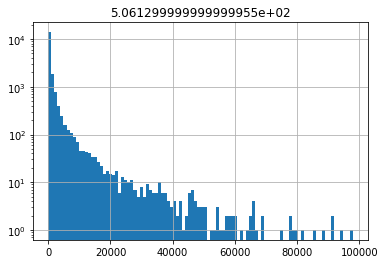

In [14]:
pd_y_paid.hist(bins=100, log=True)

### 2.2 Data augmentation

In [15]:
print("pd_x: {}".format(pd_x.shape))
print("pd_y_paid: {}".format(pd_y_paid.shape))

pd_x: (18291, 606)
pd_y_paid: (18291, 1)


In [16]:
# Data split
# https://github.com/Diyago/GAN-for-tabular-data
from tabgan.sampler import OriginalGenerator, GANGenerator
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    pd_x, pd_y_paid, test_size=0.9, random_state=42)

print("X_train: {}".format(X_train.shape))
print("X_test: {}".format(X_test.shape))
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))



X_train: (1829, 606)
X_test: (16462, 606)
y_train: (1829, 1)
y_test: (16462, 1)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [17]:
X_train.to_csv(EMB_DATA_PATH + 'X_train.csv', index = False, header=True)
X_test.to_csv(EMB_DATA_PATH + 'X_test.csv', index = False, header=True)
y_train.to_csv(EMB_DATA_PATH + 'y_train.csv', index = False, header=True)
y_test.to_csv(EMB_DATA_PATH + 'y_test.csv', index = False, header=True)

In [18]:
# Categorical col name selection for the Tabuler GAN
cat_cols = [col for col in pd_x.columns if pd_x[col].max() > 3000]
print(cat_cols)
print(len(cat_cols))
print(pd_x.shape[0] - len(cat_cols))

['3.487200000000000273e+02', '1.521259999999999764e+03', '2.509269999999999982e+03', '2.238440000000000055e+03', '1.432959999999999809e+03', '0.000000000000000000e+00.476']
6
18285


In [19]:
# For the CUDA out of memory
# https://github.com/pytorch/pytorch/issues/16417
import gc
gc.collect()
torch.cuda.empty_cache()

# Data augumentation
# https://github.com/Diyago/GAN-for-tabular-data
new_train, new_target = GANGenerator(gen_x_times=1.1,
                                       cat_cols=cat_cols).generate_data_pipe(X_train, y_train,
                                                                      X_test, deep_copy=True,
                                                                      only_adversarial=False,
                                                                      use_adversarial=True)

print("new_train: {}".format(new_train.shape))
print("new_target: {}".format(new_target.shape))

new_train: (208, 606)
new_target: (208,)


In [20]:
new_train.describe()

,3.487200000000000273e+02,0.000000000000000000e+00,0.000000000000000000e+00.1,0.000000000000000000e+00.2,0.000000000000000000e+00.3,0.000000000000000000e+00.4,0.000000000000000000e+00.5,0.000000000000000000e+00.6,0.000000000000000000e+00.7,0.000000000000000000e+00.8,0.000000000000000000e+00.9,0.000000000000000000e+00.10,0.000000000000000000e+00.11,0.000000000000000000e+00.12,0.000000000000000000e+00.13,0.000000000000000000e+00.14,0.000000000000000000e+00.15,0.000000000000000000e+00.16,0.000000000000000000e+00.17,0.000000000000000000e+00.18,0.000000000000000000e+00.19,0.000000000000000000e+00.20,0.000000000000000000e+00.21,0.000000000000000000e+00.22,0.000000000000000000e+00.23,0.000000000000000000e+00.24,0.000000000000000000e+00.25,0.000000000000000000e+00.26,0.000000000000000000e+00.27,0.000000000000000000e+00.28,0.000000000000000000e+00.29,0.000000000000000000e+00.30,0.000000000000000000e+00.31,0.000000000000000000e+00.32,0.000000000000000000e+00.33,0.000000000000000000e+00.34,0.000000000000000000e+00.35,0.000000000000000000e+00.36,0.000000000000000000e+00.37,0.000000000000000000e+00.38,...,0.000000000000000000e+00.537,0.000000000000000000e+00.538,0.000000000000000000e+00.539,0.000000000000000000e+00.540,0.000000000000000000e+00.541,0.000000000000000000e+00.542,0.000000000000000000e+00.543,0.000000000000000000e+00.544,0.000000000000000000e+00.545,0.000000000000000000e+00.546,0.000000000000000000e+00.547,0.000000000000000000e+00.548,0.000000000000000000e+00.549,0.000000000000000000e+00.550,0.000000000000000000e+00.551,0.000000000000000000e+00.552,0.000000000000000000e+00.553,0.000000000000000000e+00.554,0.000000000000000000e+00.555,0.000000000000000000e+00.556,0.000000000000000000e+00.557,0.000000000000000000e+00.558,0.000000000000000000e+00.559,0.000000000000000000e+00.560,0.000000000000000000e+00.561,0.000000000000000000e+00.562,0.000000000000000000e+00.563,0.000000000000000000e+00.564,0.000000000000000000e+00.565,0.000000000000000000e+00.566,0.000000000000000000e+00.567,0.000000000000000000e+00.568,0.000000000000000000e+00.569,0.000000000000000000e+00.570,0.000000000000000000e+00.571,0.000000000000000000e+00.572,0.000000000000000000e+00.573,0.000000000000000000e+00.574,0.000000000000000000e+00.575,0.000000000000000000e+00.576
count,208.000000,208.000000,208.000000,208.0,208.000000,208.000000,208.0,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.0,208.0,208.0,208.0,208.000000,208.0,208.000000,208.000000,208.000000,208.000000,208.0,208.0,208.000000,208.0,208.0,208.0,208.0,208.000000,208.0,208.000000,208.000000,208.000000,208.000000,208.000000,208.0,208.000000,...,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.000000,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.000000,208.0,208.0,208.0,208.000000,208.0
mean,57.117308,1.081731,0.043269,0.0,0.014423,0.004808,0.0,0.014423,0.014423,0.014423,0.033654,0.019231,0.004808,0.014423,0.0,0.0,0.0,0.0,0.028846,0.0,0.004808,0.004808,0.009615,0.043269,0.0,0.0,0.014423,0.0,0.0,0.0,0.0,0.019231,0.0,0.014423,0.019231,0.033654,0.019231,0.024038,0.0,0.038462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009615,0.0,0.0,0.0,0.009615,0.0
std,101.546515,2.296406,0.226404,0.0,0.154744,0.069338,0.0,0.119515,0.119515,0.119515,0.180772,0.137666,0.069338,0.119515,0.0,0.0,0.0,0.0,0.167778,0.0,0.069338,0.069338,0.097821,0.226404,0.0,0.0,0.119515,0.0,0.0,0.0,0.0,0.137666,0.0,0.119515,0.137666,0.180772,0.195642,0.153538,0.0,0.378736,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.138675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.138675,0.0,0.0,0.0,0.138675,0.0
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.

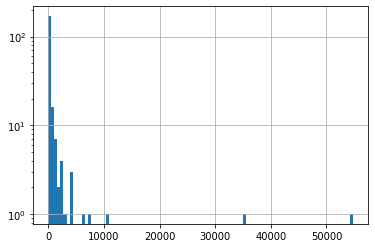

In [21]:
new_target.hist(bins=100, log=True)

Save to CSV

In [22]:
new_train.to_csv(EMB_DATA_PATH + 'new_train.csv', index = False, header=True)
new_target.to_csv(EMB_DATA_PATH + 'new_train.csv', index = False, header=True)